In [290]:
RANDOM_STATE = 1

# Imports

In [291]:
import pandas as pd
import time
import numpy as np
import pickle
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',300)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

In [292]:
from nltk.corpus import stopwords
import re
import nltk
from nltk import tokenize
from nltk.stem import WordNetLemmatizer

In [293]:
import spacy

# Import datasets from drive

Note - for the purpose of brevity, data has already been preprocessed and cleaned.

In [294]:
#from google.colab import drive
#drive.mount('/content/drive')

In [295]:
import math

In [296]:
# TODO: modify these list if needed (eg. if you want to load only 1 csv from star3, delete other csvs in star3 list)
mbs = ['cleaned_mbs_total.csv']
bencoolen = ['cleaned_ibis-sg-bencoolen.csv']
paradox = ['cleaned_paradox-sg-merchant-court.csv']
star3 = ['cleaned_ibis-sg-bencoolen.csv','cleaned_hotel-boss.csv','cleaned_hotel-G.csv',
           'cleaned_village-hotel-albert-court-by-far-east-hospitality.csv',
           'cleaned_holiday-inn-express-clarke-quay.csv']
star4 = ['cleaned_village-hotel-changi-by-far-east-hospitality.csv',
         'cleaned_park-regis.csv', 'cleaned_grand-mercure-sg-roxy.csv',
         'cleaned_paradox-sg-merchant-court.csv','cleaned_crowne-plaza.csv']
star5 = ['cleaned_fullerton.csv', 'cleaned_parkroyal-collection-marina-bay.csv', 'cleaned_pan-pacific.csv',
          'cleaned_mbs_total.csv', 'cleaned_swissotel-the-stamford.csv']
ROOT = ''
RAW_FOLDER = "..\\data\\processed"
def filter_date(row):
  try:
    #print(int(row["date_of_stay"][-4:]))
    print(row["date_of_stay"][-4:])
    return int(row["date_of_stay"][-4:])
  except:
    #print("2000")
    return 2000
def combine_csv_to_dataframe(file_names, all_star = False, filterDate = True):
    """
    Combine multiple CSV files into a single DataFrame.

    Parameters:
    file_names (list): List of CSV file names. 
    all_star (bool): whether or not to load all the hotels (False if only want to load 1 type of hotel star). 
    filterData (bool): whether or not to remove all data dated before 2015

    Returns:
    pd.DataFrame: Combined DataFrame.
    """
    combined_df = pd.DataFrame()

    for file_name in file_names:
        file_name = RAW_FOLDER + "\\" + file_name
        try:
            df = pd.read_csv(file_name)
            if all_star:
              if file_name in star3:
                df["star"] = 3
              elif file_name in star4:
                df["star"] = 4
              else:
                df["star"] = 5
            print(f"Length of {file_name} is {len(df)}")
            combined_df = pd.concat([combined_df, df], ignore_index=True)
        except FileNotFoundError:
            print(f"File not found: {file_name}")
        except pd.errors.EmptyDataError:
            print(f"Empty or invalid CSV file: {file_name}")
    if filterDate:
      combined_df["year"] = combined_df.apply(lambda row: filter_date(row), axis = 1)
      combined_df = combined_df[combined_df["year"]>=2015]
    return combined_df

In [297]:
#data_path = '/content/drive/MyDrive/BT4222/data/mbs_reviews.csv'
df = combine_csv_to_dataframe(star3+star4+star5, all_star = True, filterDate = False)

Length of ..\data\processed\cleaned_ibis-sg-bencoolen.csv is 2217
Length of ..\data\processed\cleaned_hotel-boss.csv is 3568
Length of ..\data\processed\cleaned_hotel-G.csv is 3826
Length of ..\data\processed\cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 2290
Length of ..\data\processed\cleaned_holiday-inn-express-clarke-quay.csv is 2169
Length of ..\data\processed\cleaned_village-hotel-changi-by-far-east-hospitality.csv is 4325
Length of ..\data\processed\cleaned_park-regis.csv is 4719
Length of ..\data\processed\cleaned_grand-mercure-sg-roxy.csv is 2317
Length of ..\data\processed\cleaned_paradox-sg-merchant-court.csv is 3571
Length of ..\data\processed\cleaned_crowne-plaza.csv is 3668
Length of ..\data\processed\cleaned_fullerton.csv is 6374
Length of ..\data\processed\cleaned_parkroyal-collection-marina-bay.csv is 6237
Length of ..\data\processed\cleaned_pan-pacific.csv is 7430
Length of ..\data\processed\cleaned_mbs_total.csv is 10523
Length of ..\data\processe

In [298]:
DATANAME = "ALLDATA"

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68292 entries, 0 to 68291
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             68292 non-null  int64  
 1   traveller_username                     68292 non-null  object 
 2   review_title                           68285 non-null  object 
 3   review_text                            68292 non-null  object 
 4   travel_type                            31354 non-null  object 
 5   traveller_country_origin               51724 non-null  object 
 6   traveller_total_contributions          68103 non-null  object 
 7   traveller_total_helpful_contributions  54090 non-null  float64
 8   rating                                 54837 non-null  float64
 9   valid_rating                           68292 non-null  bool   
 10  label                                  54837 non-null  object 
 11  cl

# Data Preprocessing

Then, we split the data into train and validation sets using train_test_split.

In [300]:
df.dropna(subset=['label'], inplace=True)


In [301]:
df = df[df["label"]!='Neutral']

In [302]:
df['label'] = df['label'].astype('category')


In [303]:
train_set, test_set = train_test_split(df[['lem_review','label']],
                                      test_size=0.2,
                                      shuffle=True,
                                      random_state=RANDOM_STATE)
X_train = train_set.lem_review
y_train = train_set.label
X_test = test_set.lem_review
y_test = test_set.label

In [304]:
train_set

,lem_review,label
61530,amazing swimpool really great amazing view room ok garden bay view really like scent toiletry mbs skypark really full son birthday cake mbs compliment like,Positive
25354,quick singapore stayover modern well equip facility nice pool area half way airport city walk distance beach area local market choice resturant staff courteous helpful adjoining shopping mall wide variety shop include beauty treatment nail massage hairdressing,Positive
53325,worth hype iconic hotel heart singapore iconic hotel set standard luxury amongst singaporean hotel city young beautiful head hour classy cocktail fine dining gambling course plenty tourist visit world famous observation deck afford stunning view lion city room marina bay sands huge modern incred...,Positive
1900,ibis bencoolen great stay use place hour stopover singapore en route sydney amsterdam central amazingly professional friendly staff easy get clean efficient room helpful staff perfect wifi stay singapore good value job book hour stopover go back,Positive
51511,beautiful property beautiful city stay pan pacific singapore four night end asia cruise end march earlyapril hotel exceptional every way grand atrium spacious room comfort singapore close equator hot come back cool room wonderful shower cozy robe slipper comfy bed refreshing breakfast buffet wou...,Positive
...,...,...
68191,ok hotel we wi fi nice modern convenient hotel spacious room great view accessible via mrt however charge singapore dollar hour wi fi access ridiculous first singapore prides intelligent island drown bandwidth second fishing hut rural cambodia provide free internet access,Positive
48916,wow pan pacific hotel high rate premium quality hotel singapore stay day travel hong kong hotel gem staff well mannered polite professional accommodate hotel nice view great dining experience good restaurant love breakfast pool amazing gym great room equip nice king size bed spacious update loca...,Positive
6047,amazing stay staff stay hotel g singapore couple night everything excellent manager daryl super nice provide we excellent service time staff stay location everything perfect come back sure,Positive
13901,great location great value spend night hotel honestly say absolute pleasure start finish room small clean new breakfast good selection suit taste location also spot city attraction china town clarke quay ect staff friendly first visit singapore helpful tourist inquiry also hour wait time checkou...,Positive


In [305]:
y_train.value_counts()

Positive    37729
Negative     2381
Name: label, dtype: int64

The data is very imbalanced, so we will perform undersampling on the train data.

In [306]:
train_set['label'] = train_set['label'].astype('category')


In [307]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train, y_train = rus.fit_resample(train_set, train_set['label'])
train_set = shuffle(X_train)
train_set.reset_index(inplace=True, drop=True)

In [308]:
X_train = train_set['lem_review']
y_train = train_set['label']

In [309]:
y_train.value_counts()

Negative    2381
Positive    2381
Name: label, dtype: int64

We can now use this data for training and testing. To use text data in our machine learning models, we first convert them into TF-IDF vectors.

In [310]:
vectorizer = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
tfidf_features_train = vectorizer.fit_transform(X_train)
tfidf_features_test = vectorizer.transform(X_test)

In [311]:
# save the model to disk
filename = 'tfidf_vectorizer.sav'
pickle.dump(vectorizer, open(filename, 'wb'))

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

# Machine Learning Models

## Logistic Regression model

In [312]:
param_grid = {"C":np.logspace(-3,3,7),
              "penalty":["l1","l2"]
              }

lr_model = GridSearchCV(LogisticRegression(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)

#lr_model = LogisticRegression(C=10.0,penalty='l2')
lr_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             verbose=5)

In [313]:
print('Best Parameters found : {}'.format(lr_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(lr_model.best_score_))

Best Parameters found : {'C': 1000.0, 'penalty': 'l2'}
Best Accuracy found : 0.939



Evaluation on test set

In [314]:
predictions = lr_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=lr_model.classes_)

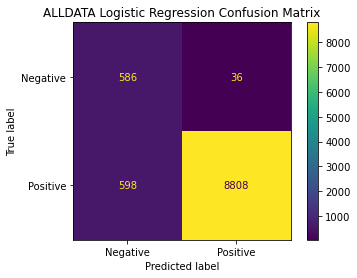

In [315]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
disp.plot()
plt.title(f"{DATANAME} Logistic Regression Confusion Matrix")
plt.show()


In [316]:

t1 = time.time()

predictions = lr_model.predict(tfidf_features_test)
t2 = time.time()
print(f"REPORT FOR {DATANAME} LOGISTIC REGRESSION")
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=lr_model.classes_))

REPORT FOR ALLDATA LOGISTIC REGRESSION
Time Taken 0.005009174346923828 s, 2001926.7259400287 rows per s
              precision    recall  f1-score   support

    Negative       0.49      0.94      0.65       622
    Positive       1.00      0.94      0.97      9406

    accuracy                           0.94     10028
   macro avg       0.75      0.94      0.81     10028
weighted avg       0.96      0.94      0.95     10028

[[ 586   36]
 [ 598 8808]]


## Multinomial Naive Bayes Model

In [317]:
param_grid =  {'alpha':[0, 0.01, 0.1, 0.5, 1.0, 10.0],
               'fit_prior': [True, False],
               'class_prior': [None, [0.1,]*3]
              }

nb_model = GridSearchCV(MultinomialNB(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#nb_model = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nb_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0, 0.01, 0.1, 0.5, 1.0, 10.0],
                         'class_prior': [None, [0.1, 0.1, 0.1]],
                         'fit_prior': [True, False]},
             verbose=5)

In [318]:
print('Best Parameters found : {}'.format(nb_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(nb_model.best_score_))

Best Parameters found : {'alpha': 0.5, 'class_prior': None, 'fit_prior': True}
Best Accuracy found : 0.935



Evaluation on test set

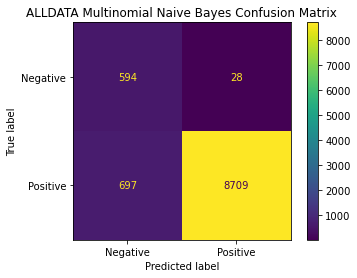

In [319]:
predictions = nb_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)

disp.plot()
plt.title(f"{DATANAME} Multinomial Naive Bayes Confusion Matrix")
plt.show()

In [320]:

t1 = time.time()

predictions = nb_model.predict(tfidf_features_test)
t2 = time.time()
print(f"REPORT FOR {DATANAME} MULTINOMIAL NAIVE BAYES")
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=nb_model.classes_))

REPORT FOR ALLDATA MULTINOMIAL NAIVE BAYES
Time Taken 0.028732776641845703 s, 349009.0820319631 rows per s
              precision    recall  f1-score   support

    Negative       0.46      0.95      0.62       622
    Positive       1.00      0.93      0.96      9406

    accuracy                           0.93     10028
   macro avg       0.73      0.94      0.79     10028
weighted avg       0.96      0.93      0.94     10028

[[ 594   28]
 [ 697 8709]]


## Linear SVM

In [321]:
param_grid =  {'C':[0, 0.01, 0.1, 0.5, 1.0, 10.0],
               'dual': [True, False],
               'penalty': ['l1','l2'],
              }

lsvm_model = GridSearchCV(sklearn.svm.LinearSVC(random_state=RANDOM_STATE),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#lsvm_model = sklearn.svm.LinearSVC(C=1.0,dual=False,penalty='l1')
lsvm_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=LinearSVC(random_state=1), n_jobs=-1,
             param_grid={'C': [0, 0.01, 0.1, 0.5, 1.0, 10.0],
                         'dual': [True, False], 'penalty': ['l1', 'l2']},
             verbose=5)

In [322]:
print('Best Parameters found : {}'.format(lsvm_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(lsvm_model.best_score_))

Best Parameters found : {'C': 10.0, 'dual': True, 'penalty': 'l2'}
Best Accuracy found : 0.940



Evaluation on test set

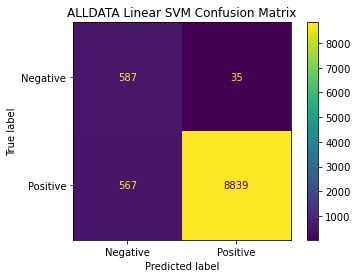

In [323]:
predictions = lsvm_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=lsvm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lsvm_model.classes_)

disp.plot()
plt.title(f"{DATANAME} Linear SVM Confusion Matrix")
plt.show()

In [324]:
t1 = time.time()

predictions = lsvm_model.predict(tfidf_features_test)
t2 = time.time()
print(f"REPORT FOR {DATANAME} LINEAR SVM")
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=lsvm_model.classes_))

REPORT FOR ALLDATA LINEAR SVM
Time Taken 0.017894506454467773 s, 560395.4501632137 rows per s
              precision    recall  f1-score   support

    Negative       0.51      0.94      0.66       622
    Positive       1.00      0.94      0.97      9406

    accuracy                           0.94     10028
   macro avg       0.75      0.94      0.81     10028
weighted avg       0.97      0.94      0.95     10028

[[ 587   35]
 [ 567 8839]]


## Random Forest Classifier

In [325]:
param_grid = {'n_estimators': [100,200],
              'max_features': ['sqrt','log2'],
              'max_depth': [5,10,15],
}

rf_model = GridSearchCV(RandomForestClassifier(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)
#rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=15)
rf_model.fit(tfidf_features_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200]},
             verbose=5)

In [326]:
print('Best Parameters found : {}'.format(rf_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(rf_model.best_score_))

Best Parameters found : {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 200}
Best Accuracy found : 0.887



Evaluate on test set

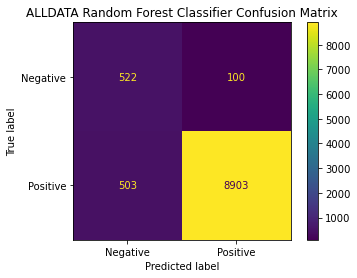

In [327]:
predictions = rf_model.predict(tfidf_features_test)
cm = confusion_matrix(y_test, predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

disp.plot()
plt.title(f"{DATANAME} Random Forest Classifier Confusion Matrix")
plt.show()

In [328]:
t1 = time.time()

predictions = rf_model.predict(tfidf_features_test)
t2 = time.time()
print(f"REPORT FOR {DATANAME} RANDOM FOREST CLASSIFIER")
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test, predictions, labels=rf_model.classes_))

REPORT FOR ALLDATA RANDOM FOREST CLASSIFIER
Time Taken 1.635437250137329 s, 6131.693526705436 rows per s
              precision    recall  f1-score   support

    Negative       0.51      0.84      0.63       622
    Positive       0.99      0.95      0.97      9406

    accuracy                           0.94     10028
   macro avg       0.75      0.89      0.80     10028
weighted avg       0.96      0.94      0.95     10028

[[ 522  100]
 [ 503 8903]]


# PRE-POST COVID 

In [329]:
df = combine_csv_to_dataframe(star3+star4+star5, all_star = True, filterDate = False)

Length of ..\data\processed\cleaned_ibis-sg-bencoolen.csv is 2217
Length of ..\data\processed\cleaned_hotel-boss.csv is 3568
Length of ..\data\processed\cleaned_hotel-G.csv is 3826
Length of ..\data\processed\cleaned_village-hotel-albert-court-by-far-east-hospitality.csv is 2290
Length of ..\data\processed\cleaned_holiday-inn-express-clarke-quay.csv is 2169
Length of ..\data\processed\cleaned_village-hotel-changi-by-far-east-hospitality.csv is 4325
Length of ..\data\processed\cleaned_park-regis.csv is 4719
Length of ..\data\processed\cleaned_grand-mercure-sg-roxy.csv is 2317
Length of ..\data\processed\cleaned_paradox-sg-merchant-court.csv is 3571
Length of ..\data\processed\cleaned_crowne-plaza.csv is 3668
Length of ..\data\processed\cleaned_fullerton.csv is 6374
Length of ..\data\processed\cleaned_parkroyal-collection-marina-bay.csv is 6237
Length of ..\data\processed\cleaned_pan-pacific.csv is 7430
Length of ..\data\processed\cleaned_mbs_total.csv is 10523
Length of ..\data\processe

In [333]:
df.head(1)

,Unnamed: 0,traveller_username,review_title,review_text,travel_type,traveller_country_origin,traveller_total_contributions,traveller_total_helpful_contributions,rating,valid_rating,label,cleaned_review,combined_review,date,covid,year,stem_review,lem_review,star
0,0,Love_Life_Sydney,Clean and comfortable,"Hotel rooms in Singapore are so expensive so to find a decent hotel, with easy transport access and food locations, at less than S$200 was a good deal. The compact room meets your basic needs, no fancy mood lightning or lovely artworks to grace the wall. It has clean sheets and towels, a small b...",Trip type: Travelled as a couple,"Sydney, Australia",2302.0,871.0,4.0,True,Positive,clean comfortable hotel rooms singapore expensive find decent hotel easy transport access food locations less good deal compact room meets basic needs fancy mood lightning lovely artworks grace wall clean sheets towels small bathroom pump pack amenities kettle glass bottle refills small selectio...,"Clean and comfortable Hotel rooms in Singapore are so expensive so to find a decent hotel, with easy transport access and food locations, at less than S$200 was a good deal. The compact room meets your basic needs, no fancy mood lightning or lovely artworks to grace the wall. It has clean sheets...",2023-08-01,PostCovid,2023,clean comfort hotel room singapor expens find decent hotel easi transport access food locat less good deal compact room meet basic need fanci mood lightn love artwork grace wall clean sheet towel small bathroom pump pack amen kettl glass bottl refil small select tea coffe small fridg room safe c...,clean comfortable hotel room singapore expensive find decent hotel easy transport access food location less good deal compact room meet basic need fancy mood lightne lovely artwork grace wall clean sheet towel small bathroom pump pack amenity kettle glass bottle refill small selection tea coffee...,5


In [359]:
precovid = df[df["covid"] == "PreCovid"]
print("number of precovid data is ", len(precovid))
postcovid = df[df["covid"] == "PostCovid"]
print("number of postcovid data is ", len(postcovid))
min_number = min(len(precovid), len(postcovid))

number of precovid data is  56020
number of postcovid data is  6951


In [360]:
min_number

6951

In [361]:
# RANDOMLY DOWNSAMPLE THE LARGER SET
precovid = precovid.sample(n=min_number)
postcovid = postcovid.sample(n=min_number)

In [362]:
print("number of precovid data is ", len(precovid))
print("number of postcovid data is ", len(postcovid))

number of precovid data is  6951
number of postcovid data is  6951


In [363]:
# Data Preprocessing
precovid.dropna(subset=['label'], inplace=True)
precovid = precovid[precovid["label"]!='Neutral']
precovid['label'] = df['label'].astype('category')

postcovid.dropna(subset=['label'], inplace=True)
postcovid = postcovid[postcovid["label"]!='Neutral']
postcovid['label'] = df['label'].astype('category')

In [366]:
train_set_pre, test_set_pre = train_test_split(precovid[['lem_review','label']],
                                      test_size=0.2,
                                      shuffle=True,
                                      random_state=RANDOM_STATE)
X_train_pre = train_set_pre.lem_review
y_train_pre = train_set_pre.label
X_test_pre = test_set_pre.lem_review
y_test_pre = test_set_pre.label

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))


In [370]:
rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_pre, y_train_pre = rus.fit_resample(train_set_pre, train_set_pre['label'])
train_set_pre = shuffle(X_train_pre)
train_set_pre.reset_index(inplace=True, drop=True)
X_train_pre = train_set_pre['lem_review']
y_train_pre = train_set_pre['label']
y_train_pre.value_counts()

Negative    226
Positive    226
Neutral       0
Name: label, dtype: int64

In [374]:
vectorizer_pre = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
tfidf_features_train_pre = vectorizer_pre.fit_transform(X_train_pre)
tfidf_features_test_pre = vectorizer_pre.transform(X_test_pre)

In [375]:
train_set_post, test_set_post = train_test_split(postcovid[['lem_review','label']],
                                      test_size=0.2,
                                      shuffle=True,
                                      random_state=RANDOM_STATE)
X_train_post = train_set_post.lem_review
y_train_post = train_set_post.label
X_test_post = test_set_post.lem_review
y_test_post = test_set_post.label

# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))

rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_train_post, y_train_post = rus.fit_resample(train_set_post, train_set_post['label'])
train_set_post = shuffle(X_train_post)
train_set_post.reset_index(inplace=True, drop=True)
X_train_post = train_set_post['lem_review']
y_train_post = train_set_post['label']
y_train_post.value_counts()
vectorizer_post = TfidfVectorizer(use_idf=True,ngram_range=(1,3))
tfidf_features_train_post = vectorizer_post.fit_transform(X_train_post)
tfidf_features_test_post = vectorizer_post.transform(X_test_post)

In [376]:
## Random Forest Classifier
param_grid = {'n_estimators': [100,200],
              'max_features': ['sqrt','log2'],
              'max_depth': [5,10,15],
}

rf_model = GridSearchCV(RandomForestClassifier(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)


In [377]:
#rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=15)
rf_model.fit(tfidf_features_train_pre, y_train_pre)
print('Best Parameters found : {}'.format(rf_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(rf_model.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters found : {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}
Best Accuracy found : 0.876



## Model trained on Pre tested on Pre

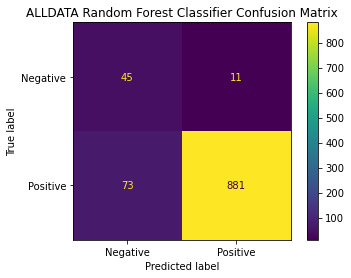

In [378]:
predictions = rf_model.predict(tfidf_features_test_pre)
cm = confusion_matrix(y_test_pre, predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

disp.plot()
plt.title(f"{DATANAME} Random Forest Classifier Confusion Matrix")
plt.show()


In [379]:
t1 = time.time()

predictions = rf_model.predict(tfidf_features_test_pre)
t2 = time.time()
print(f"REPORT FOR {DATANAME} RANDOM FOREST CLASSIFIER")
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test_pre, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test_pre, predictions, labels=rf_model.classes_))

REPORT FOR ALLDATA RANDOM FOREST CLASSIFIER
Time Taken 0.06571483612060547 s, 152598.72187150797 rows per s
              precision    recall  f1-score   support

    Negative       0.38      0.80      0.52        56
    Positive       0.99      0.92      0.95       954

    accuracy                           0.92      1010
   macro avg       0.68      0.86      0.74      1010
weighted avg       0.95      0.92      0.93      1010

[[ 45  11]
 [ 73 881]]


## Model trained on Pre tested on Post

In [381]:

tfidf_features_test_post2 = vectorizer_pre.transform(X_test_post)

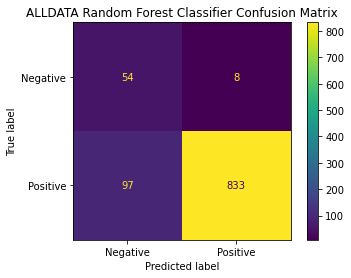

In [382]:
predictions = rf_model.predict(tfidf_features_test_post2)
cm = confusion_matrix(y_test_post, predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

disp.plot()
plt.title(f"{DATANAME} Random Forest Classifier Confusion Matrix")
plt.show()


In [383]:

t1 = time.time()

predictions = rf_model.predict(tfidf_features_test_post2)
t2 = time.time()
print(f"REPORT FOR {DATANAME} RANDOM FOREST CLASSIFIER")
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test_post, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test_post, predictions, labels=rf_model.classes_))

REPORT FOR ALLDATA RANDOM FOREST CLASSIFIER
Time Taken 0.03898739814758301 s, 257211.3163858737 rows per s
              precision    recall  f1-score   support

    Negative       0.36      0.87      0.51        62
    Positive       0.99      0.90      0.94       930

    accuracy                           0.89       992
   macro avg       0.67      0.88      0.72       992
weighted avg       0.95      0.89      0.91       992

[[ 54   8]
 [ 97 833]]


## Train model on Post

In [384]:
## Random Forest Classifier
param_grid = {'n_estimators': [100,200],
              'max_features': ['sqrt','log2'],
              'max_depth': [5,10,15],
}

rf_model = GridSearchCV(RandomForestClassifier(),
                        param_grid=param_grid,
                        n_jobs=-1,
                        verbose=5)

#rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=15)
rf_model.fit(tfidf_features_train_post, y_train_post)
print('Best Parameters found : {}'.format(rf_model.best_params_))
print('Best Accuracy found : {:.3f}\n'.format(rf_model.best_score_))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters found : {'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}
Best Accuracy found : 0.926



## Model trained on Post tested on Post

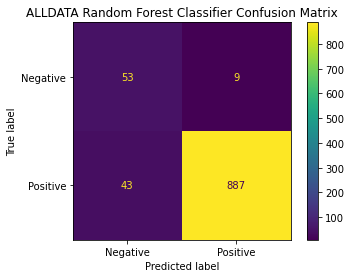

In [385]:
predictions = rf_model.predict(tfidf_features_test_post)
cm = confusion_matrix(y_test_post, predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

disp.plot()
plt.title(f"{DATANAME} Random Forest Classifier Confusion Matrix")
plt.show()

In [386]:
t1 = time.time()

predictions = rf_model.predict(tfidf_features_test_post)
t2 = time.time()
print(f"REPORT FOR {DATANAME} RANDOM FOREST CLASSIFIER")
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test_post, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test_post, predictions, labels=rf_model.classes_))

REPORT FOR ALLDATA RANDOM FOREST CLASSIFIER
Time Taken 0.0647437572479248 s, 154887.52006775793 rows per s
              precision    recall  f1-score   support

    Negative       0.55      0.85      0.67        62
    Positive       0.99      0.95      0.97       930

    accuracy                           0.95       992
   macro avg       0.77      0.90      0.82       992
weighted avg       0.96      0.95      0.95       992

[[ 53   9]
 [ 43 887]]


## Model trained on Post test on Pre

In [388]:
tfidf_features_test_pre2 = vectorizer_post.transform(X_test_pre)
predictions = rf_model.predict(tfidf_features_test_pre2)

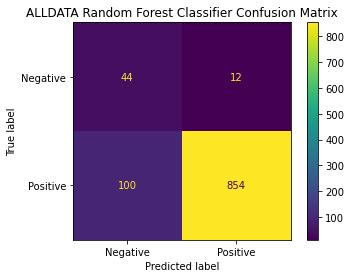

In [389]:
cm = confusion_matrix(y_test_pre, predictions, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

disp.plot()
plt.title(f"{DATANAME} Random Forest Classifier Confusion Matrix")
plt.show()

In [390]:
t1 = time.time()

predictions = rf_model.predict(tfidf_features_test_pre2)
t2 = time.time()
print(f"REPORT FOR {DATANAME} RANDOM FOREST CLASSIFIER")
print(f'Time Taken {t2-t1} s, {len(y_test)/(t2-t1)} rows per s')
print(sklearn.metrics.classification_report(y_test_pre, predictions, target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(y_test_pre, predictions, labels=rf_model.classes_))

REPORT FOR ALLDATA RANDOM FOREST CLASSIFIER
Time Taken 0.06923055648803711 s, 144849.33400373312 rows per s
              precision    recall  f1-score   support

    Negative       0.31      0.79      0.44        56
    Positive       0.99      0.90      0.94       954

    accuracy                           0.89      1010
   macro avg       0.65      0.84      0.69      1010
weighted avg       0.95      0.89      0.91      1010

[[ 44  12]
 [100 854]]
